In [1]:
import pandas as pd 
import tinkoffpy as tf
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math

import numpy as np
import numpy.typing as npt
import pandas as pd
from scipy import sparse as sps

In [2]:
conf = tf.Configuration(username='a.bogoslavskaya')
client = tf.ApiClient(conf)
gp = tf.Greenplum(client)

In [5]:
data = gp.gp_to_df("""with
applications as (
    select id
    from prod_v_ods_marketplace_grocery_catalog.application
    where
        status = 'ACTIVE'
        and json_extract_path_text(connection_info, 'apiType') = 'VKUSVILL'
)

select
    orders.created as ts,
    orders.id as order_id,
    goods.good_foreign_id as good_foreign_id
from prod_v_ods_marketplace_grocery_orders.order as orders
    inner join prod_v_ods_marketplace_grocery_orders.good_to_order as goods on
        orders.id = goods.order_id
    inner join applications on
        orders.application_id = applications.id
where (orders.created at time zone 'Europe/Moscow')::date >= '2024-04-08'
    and orders.status = 'DONE'
    and orders.id is not null
    and orders.created is not null
    and goods.good_foreign_id is not null""", gp_service='ai')

In [6]:
def mapping(col):
    return dict(zip(col.unique(), range(col.nunique())))

In [7]:
good_foreign_id_to_item_id = mapping(data["good_foreign_id"])
data["item_id"] = data["good_foreign_id"].map(good_foreign_id_to_item_id)
data["basket_id"] = data["order_id"].map(mapping(data["order_id"]))

In [8]:
# good_foreign_id_to_item_id
data

,ts,order_id,good_foreign_id,item_id,basket_id
0,2024-04-09 14:40:50.518224,300652592388,33196,0,0
1,2024-04-11 08:22:45.133797,300652611204,43240,1,1
2,2024-04-11 13:01:08.954945,300652615374,20034,2,2
3,2024-04-10 11:50:49.815456,300652602121,18735,3,3
4,2024-04-11 17:57:44.993949,300652619465,60795,4,4
...,...,...,...,...,...
232897,2024-04-10 13:11:07.605532,300652603411,15837,2516,6450
232898,2024-04-08 13:10:44.234421,300652579622,647,7,7008
232899,2024-04-09 15:45:23.313462,300652593335,647,7,13744
232900,2024-04-10 07:01:57.293417,300652598776,25276,4503,6461


In [8]:
data.head()

,ts,order_id,good_foreign_id,item_id,basket_id
0,2024-04-08 17:48:28.398229,300652583275,31755,0,0
1,2024-04-07 20:37:12.490026,300652573812,654,1,1
2,2024-04-10 16:27:37.464348,300652606000,73426,2,2
3,2024-04-07 13:16:02.70899,300652566218,16943,3,3
4,2024-04-07 19:48:14.723096,300652573132,647,4,4


In [9]:
data['ts'] = data['ts'].astype(str).apply(lambda x: x[:10])

In [11]:
grouped_items = pd.DataFrame(data.groupby(['order_id', 'ts']).agg(list).good_foreign_id).reset_index()

1.EDA (для спокойствия душевного)

In [12]:
grouped_items['lists_len'] = grouped_items.good_foreign_id.apply(lambda x: len(x))

In [13]:
grouped_items.head()
#предполагаем, что каждый пользователь делал 1 покупку через приложение - 1 набор в день = 1 баскет 
#но нужно это уточнить

,order_id,ts,good_foreign_id,lists_len
0,300652481934,2024-04-01,"[16417, 33660, 647]",3
1,300652481937,2024-04-01,"[59717, 647, 27695, 17573]",4
2,300652481938,2024-04-01,"[647, 48603, 32144]",3
3,300652481940,2024-04-01,"[16844, 28796, 79663, 647]",4
4,300652481941,2024-04-01,"[647, 69468, 66443, 85750, 71655, 78987, 76715]",7


In [14]:
grouped_items.describe()
#средний размер корзины - 7 товаров +-5
#Есть чуваки совсем выбросы - по 75-ому квантилю имеет смысл отсечь 

,order_id,lists_len
count,9.358300e+04,93583.000000
mean,3.006526e+11,7.315527
std,4.099210e+04,5.236616
min,3.006525e+11,1.000000
25%,3.006525e+11,4.000000
50%,3.006526e+11,6.000000
75%,3.006526e+11,9.000000
max,3.006526e+11,142.000000


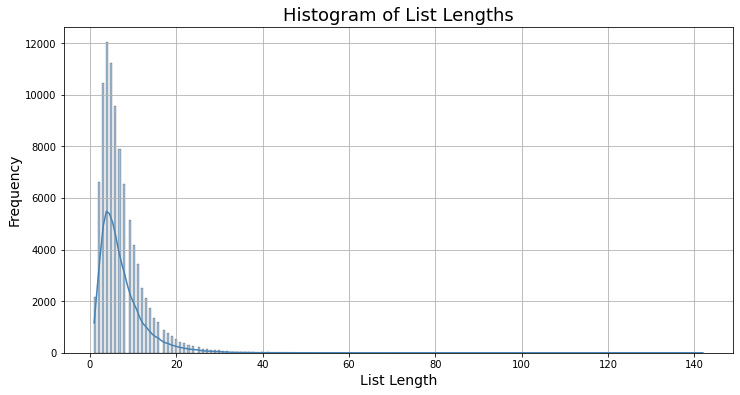

In [15]:
plt.figure(figsize=(12, 6))

sns.histplot(data=grouped_items, x='lists_len', bins=300, kde=True, color='steelblue')
plt.xlabel('List Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histogram of List Lengths', fontsize=18)
plt.grid(True)
plt.show()

#хвост из смещенного распределения влево - ожидаемо 

In [305]:
# data.dates.max(), data.dates.min()

In [16]:
# data['ts'] = data.ts.apply(lambda x: x[:10])

In [95]:
# sample_test = data[data.basket_id <= 200]

In [96]:
data

,ts,order_id,good_foreign_id,item_id,basket_id
0,2024-04-08,300652583275,31755,0,0
1,2024-04-07,300652573812,654,1,1
2,2024-04-10,300652606000,73426,2,2
3,2024-04-07,300652566218,16943,3,3
4,2024-04-07,300652573132,647,4,4
...,...,...,...,...,...
684604,2024-04-10,300652608669,46392,2161,35558
684605,2024-04-02,300652494718,18571,135,92789
684606,2024-04-07,300652568869,16540,502,24042
684607,2024-04-02,300652502666,67009,1027,10524


In [97]:
user2idx = {v: k for k, v in enumerate(data.order_id.unique())}
item2idx = {v: k for k, v in enumerate(data.item_id.unique())}
print(len(item2idx))

idx2user = {k:v for v, k in user2idx.items()}
idx2item = {k:v for v, k in item2idx.items()}

10309


In [10]:
#2/3 месяца на обучение, ост - на тест
mask = data['ts'] <= '2024-04-10'
train = data[mask]
test = data[~mask]

In [11]:
train.shape, test.shape

((174229, 5), (58673, 5))

In [32]:
# test_20_pp = test.copy()
#для 20% баскетов из теста маскируем айтемы - которые потом предскажем? 
#то есть сокращаем бакеты на 20% для каждой пары дата-юзер? 

In [71]:
# test_20_pp = pd.DataFrame(test_20_pp.groupby(['basket_id']).agg(list).item_id).reset_index()
# test_20_pp

In [34]:
# test_20_pp['lists_len'] = test_20_pp.item_id.apply(lambda x: len(x))

In [72]:
# test_20_pp['num_to_mask'] = test_20_pp['lists_len'].apply(lambda x: math.ceil(x * 0.2))
# test_20_pp

In [360]:
# indices = random.sample(range(len(test_20_pp.iloc[0].item_id)), test_20_pp.iloc[0].num_to_mask)
# indices

In [36]:
# def mask_values(lst, num):
#     curr_lst = lst.copy()  
#     indices_to_remove = random.sample(range(len(curr_lst)), num)
#     for index in sorted(indices_to_remove, reverse=True):
#         del curr_lst[index]
#     return curr_lst

# test_20_pp['list_to_pred'] = test_20_pp.apply(lambda row: mask_values(row['item_id'], row['num_to_mask']), axis=1)

In [40]:
# test_20_pp_masked = test_20_pp[['basket_id', 'list_to_pred', 'num_to_mask']]
# test_20_pp_masked = test_20_pp_masked.explode('list_to_pred')

In [73]:
# test_20_pp_masked

In [118]:
len(test.basket_id.unique()), len(train.basket_id.unique())

(8230, 85353)

2. EASE

In [12]:
baskets = train[['basket_id', 'item_id']]

# baskets["item_id"] = baskets["item_id"].factorize()[0]
# baskets["basket_id"] = baskets["basket_id"].factorize()[0]

In [13]:
def fit(baskets: pd.DataFrame, reg_weight: float = 100.0) -> npt.NDArray[np.float32]:
    x = sps.csr_matrix(
        (
            np.ones(len(baskets), dtype=np.float32),
            (baskets["basket_id"], baskets["item_id"]),
        ),
        shape=(baskets["basket_id"].nunique(), baskets["item_id"].nunique()),
    )

    g = (x.T @ x).todense()
    g += reg_weight * np.identity(g.shape[0], dtype=np.float32)

    p = np.linalg.inv(g)
    b = p / (-np.diag(p))
    np.fill_diagonal(b, 0.0)
    return b

In [16]:
print("Max basket_id:", baskets["basket_id"].max())
print("Max item_id:", baskets["item_id"].max())
print("Matrix shape:", (baskets["basket_id"].nunique(), baskets["item_id"].nunique()))

Max basket_id: 32680
Max item_id: 9004
Matrix shape: (24451, 8590)


In [14]:
b = fit(baskets)

ValueError: row index exceeds matrix dimensions

In [82]:
b.shape

(1319, 1319)

In [84]:
# b

In [85]:
test.head()

,ts,order_id,good_foreign_id,item_id,basket_id
7,2024-04-11,300652619248,647,4,7
9,2024-04-11,300652621642,43762,6,9
10,2024-04-11,300652621796,88695,7,10
27,2024-04-11,300652614269,16556,20,27
48,2024-04-11,300652621183,39543,40,48


In [86]:
def get_preds(x):
    
    basket = [item2idx[t] for t in x if t in item2idx]
    
    # Составляем вектор интеракций человека
    vector = np.zeros(len(item2idx))
    vector[basket] = 1
    
    return vector

In [87]:
pred = test.groupby(['order_id'])['item_id'].agg([('basket_id', list)]).reset_index()
pred['vector'] = pred.basket_id.apply(lambda x: get_preds(x))
pred.head()

,order_id,basket_id,vector
0,300652611652,"[88, 61, 43, 802, 2335, 1799, 4106, 4, 167, 57...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1,300652611911,"[4, 4428, 1647, 482, 1323]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
2,300652612190,"[104, 5335, 4, 3098, 488, 602]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,300652614269,"[20, 3178, 6339, 61, 1496, 589, 1265, 198, 179...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4,300652614362,"[4, 2114, 2776, 760]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


In [88]:
len(pred.loc[0].vector)

1450

In [93]:
from tqdm import tqdm
scores = []
recs_for_user = []
print(pred.shape)

batch = []
# b = b.toarray()
for idx, row in tqdm(pred.iterrows(), total = pred.shape[0]):
    vector = row.vector
    
    batch.append(vector)
    if len(batch) > 10000:
        batch = np.array(batch)
        user_scores = batch.dot(b)
        user_scores = np.argsort(-user_scores)[:,:200]
        for i in range(len(user_scores)):
            recs_for_user.append(user_scores[i].tolist())
            
        batch = []
        
batch = np.array(batch)
user_scores = batch.dot(b.T)
user_scores = np.argsort(-user_scores)[:,:200]
for i in range(len(user_scores)):
    recs_for_user.append(user_scores[i].tolist())

(21, 3)


100%|█████████████████████████████████████████| 21/21 [00:00<00:00, 6593.83it/s]


ValueError: shapes (21,1450) and (1319,1319) not aligned: 1450 (dim 1) != 1319 (dim 0)

In [60]:
recs_for_user

[]

2. Метрики

"We introduce the personal scoring function, the neighborhood-based scoring, as well as our final scoring function, which combines them"  

History-basedscoring.𝐻𝑆𝐹(𝑥,𝑢),the history-based scoring function, accounts for the loyalty of a user to an item. In other words, it considers how frequently a user has purchased the item in the past. In addition to frequency, the recency of occurrences of an item is also important in predicting the next occurrence, as shown in [2, 4]. We define 𝐻𝑆𝐹(𝑥,𝑢) as follows:


$ HSF(x, u) = \sum_{t=0}^{|B_u| - 1} \frac{1\{x \in b_t\}}{|B_u| - t}$

where 1{𝑥 ∈b𝑡 } is equal to one if 𝑥 occurs in b𝑡 and zero otherwise. In this formulation, more recent occurrences of an item in the user history are given more weight.

In [149]:
sample = data[data.basket_id <= 100]
sample

,ts,order_id,good_foreign_id,item_id,basket_id,hsf_score
0,2024-03-03,300652123281,86341,0,0,1
1,2024-03-03,300652127799,39480,1,1,1
2,2024-03-19,300652319628,61752,2,2,1
3,2024-03-24,300652380376,69490,3,3,1
4,2024-03-13,300652252934,40559,4,4,1
...,...,...,...,...,...,...
2467569,2024-04-02,300652503760,18086,2741,78,1
2468353,2024-03-02,300652116453,647,6,62,1
2468682,2024-03-25,300652396031,15197,442,80,1
2468683,2024-03-20,300652338421,16025,659,81,1


In [189]:
def history_based_scoring_function(x, u, df):
    '''
    x - item_id
    u - order_id
    
    '''
    user_data = df.loc[df['order_id'] == u]
    user_data = user_data.sort_values('ts')

    score = 0
    position = 1
    for index, row in user_data.iterrows():
        if row['good_foreign_id'] == x:
            score += 1 / position
        position += 1

    return score


In [190]:
def calculate_hsf_score(row, df):
    x = row['good_foreign_id']
    u = row['order_id']
    score = history_based_scoring_function(x, u, df)

    return score

In [191]:
# history_based_scoring_function(86341, 300652123281, data)

In [192]:
sample['hsf_score'] = sample.apply(lambda row: calculate_hsf_score(row, sample), axis=1)

/var/folders/5_/m83chgx52fn_xqgyxlnvpwlh0000gp/T/ipykernel_24168/3190370640.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['hsf_score'] = sample.apply(lambda row: calculate_hsf_score(row, sample), axis=1)


In [195]:
sample

,ts,order_id,good_foreign_id,item_id,basket_id,hsf_score,BSF_score
0,2024-03-03,300652123281,86341,0,0,1.000000,0.003281
1,2024-03-03,300652127799,39480,1,1,1.000000,0.005658
2,2024-03-19,300652319628,61752,2,2,1.000000,0.006734
3,2024-03-24,300652380376,69490,3,3,1.000000,0.003803
4,2024-03-13,300652252934,40559,4,4,1.000000,0.004897
...,...,...,...,...,...,...,...
2467569,2024-04-02,300652503760,18086,2741,78,0.058824,0.002639
2468353,2024-03-02,300652116453,647,6,62,0.100000,0.346004
2468682,2024-03-25,300652396031,15197,442,80,0.083333,0.008318
2468683,2024-03-20,300652338421,16025,659,81,0.052632,0.005547


**Basket-based scoring.** To compute the score of a candidate item 𝑥 given the items that are already in the current basket, we define the basket-based scoring function 𝐵𝑆𝐹(𝑥,𝑢,b𝑐). It scores an item 𝑥 based on its past co-occurrences with the items in the user’s past baskets. It takes into account three factors while scoring an item: (i) recent baskets are more informative than older baskets, (ii) recent items in the current basket are more important than older items, and (iii) the distance between the candidate item 𝑥 and the current item 𝑥𝑖 in the past baskets is important. Formally:

$ BSF(x, u, b_c) = \sum_{i=0}^{|b_c| - 1} \frac{1}{|b_c| - i} \cdot  \sum_{t=0}^{|B_u| - 1} \frac{1\{x_i \in b_t\}}{|B_u| - t} \cdot \frac{1\{x_i \in b_t\}}{|I(x, b_t) - I(x_i, b_t)|} $


In [184]:
def BSF(x, u, b_c):
    score = 0
    for i in range(len(b_c)):
        score_bc = 0
        for t in range(len(u)):
            count_x_in_bt = 0
            for item in b_c[i]:
                if item == x:
                    count_x_in_bt += 1
            if count_x_in_bt > 0 and len(u) > t and len(b_c) > i and len(u) - t != 0 and len(b_c) - i != 0 and abs(len(u) - i) - len(u) + t + 1 != 0:
                score_bc += (1 / (len(b_c) - i)) * (1 / (len(u) - t)) * (1 / (abs(len(u) - i) - len(u) + t + 1))
        score += score_bc
    
    return score

In [164]:
grouped = sample.groupby('basket_id')['item_id'].apply(list).reset_index(name='basket_items')

In [196]:
# grouped.basket_items[grouped.basket_items.apply(lambda x: len(x)) >= 1]

In [197]:
sample

,ts,order_id,good_foreign_id,item_id,basket_id,hsf_score,BSF_score
0,2024-03-03,300652123281,86341,0,0,1.000000,0.003281
1,2024-03-03,300652127799,39480,1,1,1.000000,0.005658
2,2024-03-19,300652319628,61752,2,2,1.000000,0.006734
3,2024-03-24,300652380376,69490,3,3,1.000000,0.003803
4,2024-03-13,300652252934,40559,4,4,1.000000,0.004897
...,...,...,...,...,...,...,...
2467569,2024-04-02,300652503760,18086,2741,78,0.058824,0.002639
2468353,2024-03-02,300652116453,647,6,62,0.100000,0.346004
2468682,2024-03-25,300652396031,15197,442,80,0.083333,0.008318
2468683,2024-03-20,300652338421,16025,659,81,0.052632,0.005547


In [198]:
sample['bsf_score'] = sample.apply(lambda row: BSF(row['item_id'], 
                                               grouped[grouped['basket_id'] == row['basket_id']]['basket_items'].iloc[0], 
                                               grouped['basket_items'].tolist()), 
                               axis=1)

/var/folders/5_/m83chgx52fn_xqgyxlnvpwlh0000gp/T/ipykernel_24168/2088863474.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['bsf_score'] = sample.apply(lambda row: BSF(row['item_id'],


In [199]:
sample

,ts,order_id,good_foreign_id,item_id,basket_id,hsf_score,BSF_score,bsf_score
0,2024-03-03,300652123281,86341,0,0,1.000000,0.003281,0.003281
1,2024-03-03,300652127799,39480,1,1,1.000000,0.005658,0.005658
2,2024-03-19,300652319628,61752,2,2,1.000000,0.006734,0.006734
3,2024-03-24,300652380376,69490,3,3,1.000000,0.003803,0.003803
4,2024-03-13,300652252934,40559,4,4,1.000000,0.004897,0.004897
...,...,...,...,...,...,...,...,...
2467569,2024-04-02,300652503760,18086,2741,78,0.058824,0.002639,0.002639
2468353,2024-03-02,300652116453,647,6,62,0.100000,0.346004,0.346004
2468682,2024-03-25,300652396031,15197,442,80,0.083333,0.008318,0.008318
2468683,2024-03-20,300652338421,16025,659,81,0.052632,0.005547,0.005547


In [202]:
def combined_scoring_function(x, u, b_c, df, alpha=0.5):
    """
    Calculate the combined score using both History-based scoring (HSF) and Basket-based scoring (BSF).
    
    Parameters:
        x (int): Item ID.
        u (int): User ID or order ID.
        b_c (list): List representing the current basket.
        df (DataFrame): DataFrame containing the historical data.
        alpha (float): Weighting factor for HSF. Default is 0.5.
    
    Returns:
        float: Combined score.
    """
    HSF_score = history_based_scoring_function(x, u, df)
    BSF_score = BSF(x, u, b_c)
    
    combined_score = alpha * HSF_score + (1 - alpha) * BSF_score
    
    return combined_score

In [205]:
# sample['PSF'] = sample.apply(lambda row: combined_scoring_function(row['item_id'], row['order_id'],
#                                                                   [row['item_id']], sample), axis=1)